<a href="https://colab.research.google.com/github/StanciuAlin/Crypto-Trend-DeepLearning/blob/main/Crypto_Trend_Prediction_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Short-Term Crypto Trend Prediction using Deep Learning

Library imports and set seed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

# Setăm seed-ul pentru reproductibilitate (cerință metodologie)
np.random.seed(42)
tf.random.set_seed(42)

Load the data from Yahoo Finance, preprocessing and normalizing

In [2]:
# --- Celula 2: Încărcarea Datelor ---
# Folosim auto_adjust=True pentru a ne asigura că avem coloana 'Close' curată [cite: 13, 15]
df = yf.download('BTC-USD', start='2020-01-01', end='2026-01-01', auto_adjust=True)

# Verificăm dacă datele au fost descărcate corect
if df.empty:
    print("Eroare: Nu s-au putut descărca datele. Verifică conexiunea la internet.")
else:
    # Extragem prețul de închidere și ne asigurăm că este un array 2D (cerință MinMaxScaler) [cite: 15, 51]
    dataset = df[['Close']].values
    print(f"Date descărcate cu succes! Formă set date: {dataset.shape}")

# --- Celula 3: Preprocesarea ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset) # Acum dataset are minim 1 feature

prediction_days = 60
X_train, y_train = [], []

for i in range(prediction_days, len(scaled_data)):
    X_train.append(scaled_data[i-prediction_days:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

[*********************100%***********************]  1 of 1 completed

Date descărcate cu succes! Formă set date: (2192, 1)


The Architecture for LSTM Model

In [3]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2), # Prevenire overfitting [cite: 124]
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1) # Predicția prețului următor
])

model.compile(optimizer='adam', loss='mean_squared_error')
# Antrenăm modelul
model.fit(X_train, y_train, batch_size=32, epochs=20)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0316
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012
Epoch 15/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011
Epoch 16/20
67/

Model testing and prediction

In [4]:
# Pregătim datele de test (ultimele 20% din setul de date)
test_size = int(len(dataset) * 0.2)
test_data = scaled_data[len(scaled_data) - test_size - prediction_days:]

X_test = []
y_test = dataset[len(dataset) - test_size:] # Prețurile reale (nu cele scalate)

for i in range(prediction_days, len(test_data)):
    X_test.append(test_data[i-prediction_days:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Realizăm predicțiile
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) # Revenim la prețul în USD

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Compute metrics

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Root Mean Squared Error (RMSE): 3518.71
Mean Absolute Error (MAE): 2698.53


Baseline Ploting

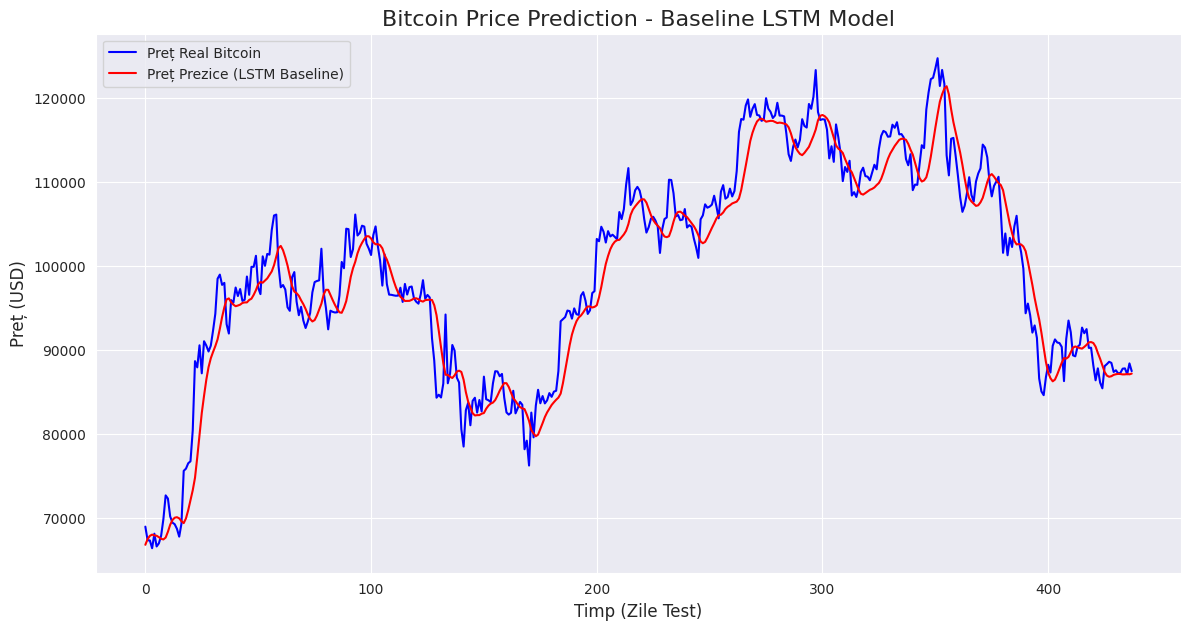

In [6]:
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(figsize=(14, 7))
plt.plot(y_test, color='blue', label='Preț Real Bitcoin')
plt.plot(predictions, color='red', label='Preț Prezice (LSTM Baseline)')
plt.title('Bitcoin Price Prediction - Baseline LSTM Model', fontsize=16)
plt.xlabel('Timp (Zile Test)', fontsize=12)
plt.ylabel('Preț (USD)', fontsize=12)
plt.legend()
plt.show()

Extension - Hybrid Model LSTM-CNN

In [7]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Input

# --- Celula 6: Arhitectura Hibridă LSTM-CNN  ---
hybrid_model = Sequential([
    Input(shape=(X_train.shape[1], 1)), # Rezolvă UserWarning-ul anterior

    # Partea de CNN: extragere de trăsături locale [cite: 10]
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Partea de LSTM: dependențe temporale [cite: 9]
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),

    Dense(units=25),
    Dense(units=1)
])

hybrid_model.compile(optimizer='adam', loss='mean_squared_error')
hybrid_model.summary() # Afișează structura rețelei [cite: 75]

# Antrenăm modelul hibrid
print("\nAntrenare Model Hibrid LSTM-CNN...")
history_hybrid = hybrid_model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 29, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 29, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,757 (174.83 KB)

 Trainable params: 44,757 (174.83 KB)

 Non-trainable params: 0 (0.00 B)


Antrenare Model Hibrid LSTM-CNN...
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0321
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0026
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0023
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0023
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014
Epoch 15/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/

Baseline (LSTM) vs Extins (LSTM-CNN)



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
--- Rezultate Experimentale (Tabelul 1 din Raport) ---
            Metric  Baseline (LSTM)  Hybrid (LSTM-CNN)
        RMSE (USD)      3518.712791        5404.414574
         MAE (USD)      2698.527005        4470.555606
Trend Accuracy (%)        48.054920          50.114416


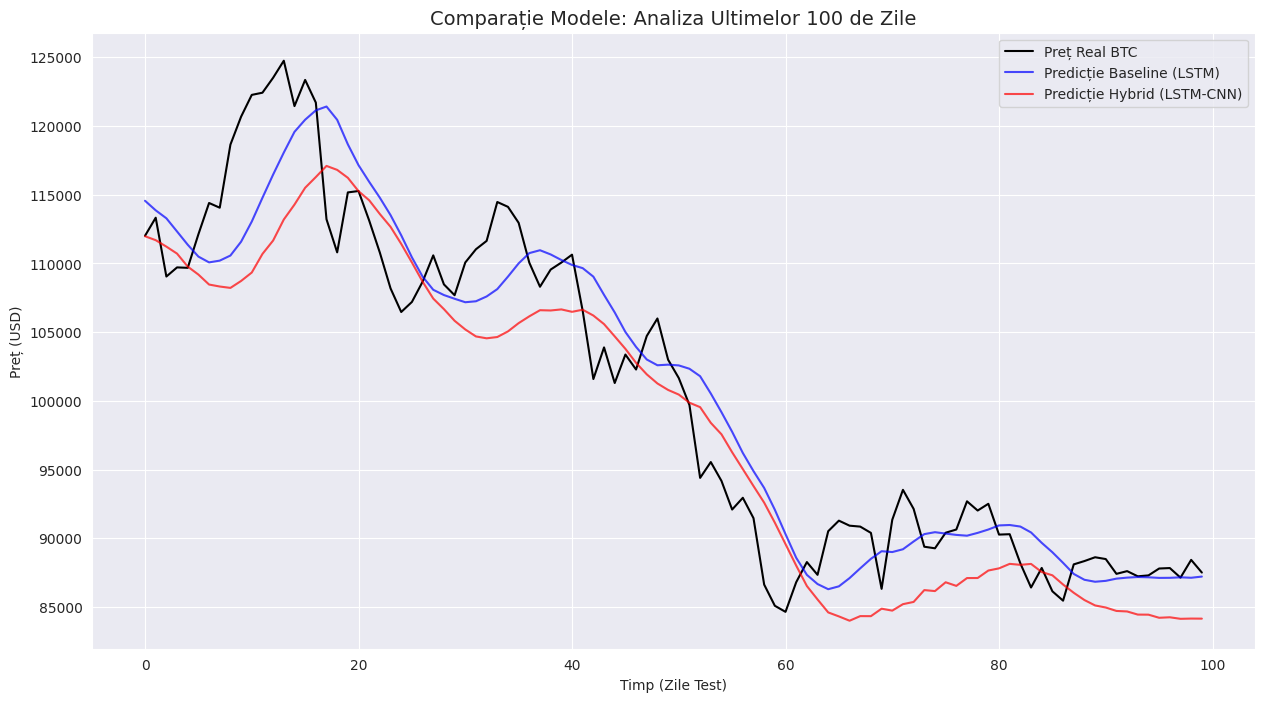

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

def evaluate_models_academic(y_true, pred_baseline, pred_hybrid):
    # 1. Calculăm metricile de eroare standard
    metrics = {
        'Metric': ['RMSE (USD)', 'MAE (USD)', 'Trend Accuracy (%)'],
        'Baseline (LSTM)': [
            np.sqrt(mean_squared_error(y_true, pred_baseline)),
            mean_absolute_error(y_true, pred_baseline),
            0 # Placeholder
        ],
        'Hybrid (LSTM-CNN)': [
            np.sqrt(mean_squared_error(y_true, pred_hybrid)),
            mean_absolute_error(y_true, pred_hybrid),
            0 # Placeholder
        ]
    }

    # 2. Calculăm Trend Accuracy (Direcția mișcării) [cite: 23, 47]
    # Verificăm dacă modelul a prezis corect dacă prețul crește sau scade față de ziua anterioară
    def calculate_trend_acc(true, pred):
        true_diff = np.diff(true.flatten())
        pred_diff = np.diff(pred.flatten())
        correct_direction = np.sign(true_diff) == np.sign(pred_diff)
        return (np.sum(correct_direction) / len(true_diff)) * 100

    metrics['Baseline (LSTM)'][2] = calculate_trend_acc(y_true, pred_baseline)
    metrics['Hybrid (LSTM-CNN)'][2] = calculate_trend_acc(y_true, pred_hybrid)

    # Creăm un DataFrame pentru un tabel profesional in raport [cite: 63]
    results_df = pd.DataFrame(metrics)
    return results_df

# Generăm predicțiile pentru modelul hibrid
predictions_hybrid = hybrid_model.predict(X_test)
predictions_hybrid = scaler.inverse_transform(predictions_hybrid)

# Rulăm evaluarea
comparison_table = evaluate_models_academic(y_test, predictions, predictions_hybrid)
print("--- Rezultate Experimentale (Tabelul 1 din Raport) ---")
print(comparison_table.to_string(index=False))

# Vizualizare Comparativă (Figura 2 din Raport)
plt.figure(figsize=(15, 8))
plt.plot(y_test[-100:], label='Preț Real BTC', color='black', linewidth=1.5)
plt.plot(predictions[-100:], label='Predicție Baseline (LSTM)', color='blue', alpha=0.7)
plt.plot(predictions_hybrid[-100:], label='Predicție Hybrid (LSTM-CNN)', color='red', alpha=0.7)
plt.title('Comparație Modele: Analiza Ultimelor 100 de Zile', fontsize=14)
plt.xlabel('Timp (Zile Test)')
plt.ylabel('Preț (USD)')
plt.legend()
plt.show()